# Neuron Construction with STDP Convergence Predictions

This document gives an example of constructing spiking neurons that detect activity patterns using predictions of spike-timing-dependent plasticity convergence.
Simulated experiments performed by Masquelier et al. (2009) have demonstrated that adapting synapses through spike-timing-dependent plasticity can tune neurons to detect one or more patterns of spikes concealed in the input activity.

Input activity with concealed patterns of spikes will be generated and neurons construct neurons that spike at a specific times in response to concealed patterns.
First, let's simulate some input activity and see how a model of a spiking neurons responds to that activity.

## Presynaptic Spike-Time Generation

The input activity used in these experiments is pregenerated.
First the simulation time is divided into segments. 
Segments are then randomly assigned to patterns until 1/3 of the segments contain a pattern.
The same spike pattern cannot occur consecutively and only one pattern is present at a time.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(0)
sim_time = 67500  # 150 repetitions for each of 3 patterns
dt = 1
pattern_n = 3

#pre-selecting the segments of simulation activity that will have a repetition of a pattern
segment_time = 50
segment_steps = segment_time//dt
segment_n = sim_time//segment_time
segment_available = np.full((segment_n, pattern_n), True)
pattern_repeat_n = segment_n//(3 * pattern_n)
pattern_segment_ind = np.zeros((pattern_repeat_n, pattern_n), dtype='int')
pattern_segment_list = np.zeros((pattern_repeat_n*pattern_n,2), dtype='int')

pattern_seq = np.arange(3)
for repeat_n in range(pattern_repeat_n):
    np.random.shuffle(pattern_seq)
    for p in pattern_seq:
        available = np.argwhere(segment_available[:,p])
        segment_select = np.random.choice(available.flatten())
        pattern_segment_ind[repeat_n,p] = segment_select
        segment_available[segment_select,:] = False
        if segment_select > 0:
            segment_available[segment_select-1,p] = False
        if segment_select < segment_n-1:
            segment_available[segment_select+1,p] = False
    pattern_segment_list[repeat_n*pattern_n:(repeat_n+1)*pattern_n:1, 0] = pattern_segment_ind[repeat_n,:]
    pattern_segment_list[repeat_n*pattern_n:(repeat_n+1)*pattern_n:1, 1] = np.arange(3, dtype='int')


pattern_segment_ind.sort(axis=0)
pattern_segment_base = np.zeros(pattern_n, dtype='int')
for p in range(pattern_n):
    pattern_segment_base[p] = pattern_segment_ind[np.random.randint(pattern_repeat_n),p]
pattern_segment_list = np.array(pattern_segment_list[pattern_segment_list[:,0].argsort(axis=0),:])
print('Pattern repetition segements selected')
print('Base patterns occur in segments: ' + str(pattern_segment_base))

Pattern repetition segements selected
Base patterns occur in segments: [275 760 504]


Once each pattern is assigned to segments of the simulation, the spike times are generated in 1ms increments.
Each neurons had a spike rate variable in the range of 0-90Hz.
This spike rate is used to calculate probability of a spike in the 1ms increment.
Spike rates are updated in each timestep.
Spike patterns are copied from this randomly generated activity and pasted into the segments cotntaining pattern repetitions with jitter.
Random spikes are generated at a rate of 10Hz for all neurons as additional noise.

In [2]:
n_pre = 2000      # presynaptic neurons
n_pattern = 1000  # presynaptic neurons in each pattern
pattern_neuron_mask = np.full((n_pre, pattern_n), False)  # a boolean mask to select pattern neurons
for p in range(pattern_n):
    pattern_neuron_mask[:,p] = np.random.randint(2, size=n_pre, dtype=bool)

steps_silent_max = 50
steps_silent = np.random.randint(steps_silent_max, size=n_pre)

spike_times_list_max = sim_time//5
spike_times_list_count = np.zeros(n_pre, dtype='int')
spike_times_list = np.full((n_pre, spike_times_list_max), np.inf)

spike_times_list_pattern_max = 20
spike_times_list_pattern_count = np.zeros((n_pre, pattern_n), dtype='int')
spike_times_list_pattern = np.full((n_pre, spike_times_list_pattern_max, pattern_n), np.inf)    
    
r_max = 90 # maximum firing rate (Hz)
r_min = 0  # minimum firing rate (Hz)

rd_max = 1800   # maximum FR speed (Hz/s)
rd_min = -1800  # minimum FR speed (Hz/s)

rdd_max = 360   # maximum FR acceleration (Hz/s^2) 
rdd_min = -360  # minimum FR acceleration (Hz/s^2)

r_noise = 10    # additional noise firing rate

rate = (r_max - r_min) * np.random.rand(n_pre) + r_min
rate_d = (rd_max - rd_min) * np.random.rand(n_pre) + rd_min

pattern_segment_next = 0
pattern_segment_list_shape = pattern_segment_list.shape
print('Generating background activity and base patterns:')
for sim_step in range(sim_time):
    if (sim_step % 1000) == 0:
        print('Seconds generated: ' + str(sim_step / 1000) + '/' + str(sim_time / 1000) + 's')
    sim_segment = sim_step // segment_time
    rdd = (rdd_max - rdd_min) * np.random.rand(n_pre) + rdd_min
    rate_d = np.maximum(rd_min, np.minimum(rd_max, rate_d + rdd))
    rate = np.maximum(r_min, np.minimum(r_max, rate + rate_d/1000))
    steps_silent += 1
    
    f = np.logical_or((rate/1000 > np.random.rand(n_pre)), (steps_silent >= steps_silent_max))
    steps_silent[f] = 0
    
    while pattern_segment_list[pattern_segment_next,0] < sim_segment:
        if pattern_segment_next+1 < pattern_segment_list_shape[0]:
            pattern_segment_next += 1
        else:
            break
    
    if sim_segment == pattern_segment_list[pattern_segment_next,0]:
        cur_pattern = pattern_segment_list[pattern_segment_next,1] 
        
        if any(sim_segment == pattern_segment_base):
            f_pattern = np.logical_and(f, pattern_neuron_mask[:,cur_pattern])
            for f_p in np.argwhere(f_pattern):
                spike_times_list_pattern[f_p,
                                        spike_times_list_pattern_count[f_p,cur_pattern],
                                        cur_pattern] = np.random.rand() + (sim_step % segment_time)
            
            spike_times_list_pattern_count[:,cur_pattern] += f_pattern
        else:
            f = np.logical_and(f, ~pattern_neuron_mask[:,cur_pattern])

    for f_r in np.argwhere(f):
        spike_times_list[f_r,spike_times_list_count[f_r]] = np.random.rand() + sim_step
    spike_times_list_count[:] += f
    
    f = r_noise/1000 > np.random.rand(n_pre)
    for f_r in np.argwhere(f):
        spike_times_list[f_r,spike_times_list_count[f_r]] = np.random.rand() + sim_step
    spike_times_list_count[:] += f    
    
print('Seconds generated: ' + str(sim_time / 1000) + '/' + str(sim_time / 1000) + 's')
print('Background activity and base pattern generation complete')

print('Generating pattern repetitions')
spike_plot_time = 500
spike_times_pattern_repeats = np.full((n_pre, spike_plot_time//5, pattern_n), np.inf)
spike_times_pattern_repeats_count = np.zeros((n_pre, pattern_n), dtype='int')
for p_r in range(pattern_segment_list_shape[0]):
    if (p_r % 10) == 0:
        print('Pattern repetitions generated: ' + str(p_r) + '/' + str(pattern_segment_list_shape[0]))
    cur_pattern = np.array(pattern_segment_list[p_r,1], dtype=np.intp)
    for n in np.argwhere(pattern_neuron_mask[:,cur_pattern]):
        stlpc = spike_times_list_pattern_count[n,cur_pattern].astype(int)
        columns_stpr = np.arange(spike_times_pattern_repeats_count[n,cur_pattern], 
                                 spike_times_pattern_repeats_count[n,cur_pattern]+stlpc, 
                                 dtype=np.intp)
        if np.not_equal(pattern_segment_base[cur_pattern], pattern_segment_list[p_r,0]):
            columns_stl = np.arange(spike_times_list_count[n], 
                                    spike_times_list_count[n]+stlpc, 
                                    dtype=np.intp)
            columns_p = np.arange(0, stlpc, dtype=np.intp)
            spike_times_list[n,columns_stl] = spike_times_list_pattern[n,columns_p,cur_pattern] \
                    + np.random.standard_normal(size=stlpc) \
                    + pattern_segment_list[p_r,0] * segment_time
            spike_times_list_count[n] += stlpc
        # recording early pattern repetition spikes for plotting
        if pattern_segment_list[p_r,0] < spike_plot_time//segment_time:
            if n == np.amin(np.argwhere(pattern_neuron_mask[:,cur_pattern])):
                print('Recording pattern spikes [simulation segment, pattern number]: ' + str(pattern_segment_list[p_r,:]))
            if np.not_equal(pattern_segment_base[cur_pattern],pattern_segment_list[p_r,0]):
                spike_times_pattern_repeats[n,columns_stpr,cur_pattern] = spike_times_list[n,columns_stl]
            else:
                spike_times_pattern_repeats[n,columns_stpr,cur_pattern] = spike_times_list_pattern[n,columns_stpr,cur_pattern]
            spike_times_pattern_repeats_count[n,cur_pattern] += stlpc
            
print('Pattern repetitions generated: ' + str(p_r+1) + '/' + str(pattern_segment_list_shape[0]))
print('Pattern repetition generation complete')

print('Sorting neuron spikes')
spike_times_list.sort()

print('Spike time generation complete')

Generating background activity and base patterns:
Seconds generated: 0.0/67.5s
Seconds generated: 1.0/67.5s
Seconds generated: 2.0/67.5s
Seconds generated: 3.0/67.5s
Seconds generated: 4.0/67.5s
Seconds generated: 5.0/67.5s
Seconds generated: 6.0/67.5s
Seconds generated: 7.0/67.5s
Seconds generated: 8.0/67.5s
Seconds generated: 9.0/67.5s
Seconds generated: 10.0/67.5s
Seconds generated: 11.0/67.5s
Seconds generated: 12.0/67.5s
Seconds generated: 13.0/67.5s
Seconds generated: 14.0/67.5s
Seconds generated: 15.0/67.5s
Seconds generated: 16.0/67.5s
Seconds generated: 17.0/67.5s
Seconds generated: 18.0/67.5s
Seconds generated: 19.0/67.5s
Seconds generated: 20.0/67.5s
Seconds generated: 21.0/67.5s
Seconds generated: 22.0/67.5s
Seconds generated: 23.0/67.5s
Seconds generated: 24.0/67.5s
Seconds generated: 25.0/67.5s
Seconds generated: 26.0/67.5s
Seconds generated: 27.0/67.5s
Seconds generated: 28.0/67.5s
Seconds generated: 29.0/67.5s
Seconds generated: 30.0/67.5s
Seconds generated: 31.0/67.5s


The input spike activity has now been generated.
We can plot some of this input activity (50 neurons for 500ms) and see some patterns concealed within it (spike-dots with a '+' overlaid).

Pattern with most repetitions in early activity: 1


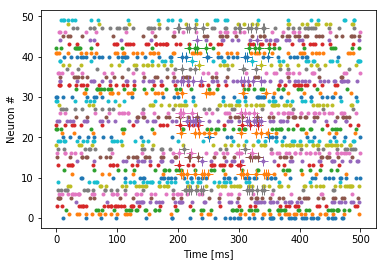

In [3]:
spike_plot_neurons = 50
spike_times_list_temp = spike_times_list[:,:250]
for n in range(spike_plot_neurons):
    spike_plot = spike_times_list_temp[n,spike_times_list_temp[n,:]<spike_plot_time]
    spike_num = spike_plot.size
    plt.plot(spike_plot,n*np.ones(spike_num),'.')

cur_pattern = np.argmax(np.sum(pattern_segment_ind<(spike_plot_time//segment_time), axis=0))
print('Pattern with most repetitions in early activity: ' + str(cur_pattern))
for n in range(spike_plot_neurons):
    spike_plot = spike_times_pattern_repeats[n,spike_times_pattern_repeats[n,:,cur_pattern]<spike_plot_time,cur_pattern]
    spike_num = spike_plot.size
    plt.plot(spike_plot, n*np.ones(spike_num), linestyle='None', marker='+', markersize=10)
    
plt.xlabel('Time [ms]')
plt.ylabel('Neuron #')
plt.show()

## Postsynaptic Neurons: Spike-Response Model

The postsynaptic neurons are each simulated using two variables with different decay time-constants which are summed to produce a model of total neuron potential.
A presynaptic spike makes an equal but opposite contribution to the variables of a postsynaptic neuron, the difference in rates of decay causes a smooth rise and fall in the total neuron potential.
When the total postsynaptic neuron potential exceeds the neuron threshold, the neuron variables are set to spike values and the neuron has a refractory period where it cannot spike.
Examples of a the contribution of a single presynaptic spike (the excitatory postsynaptic potential) and the change in potential from a postsynaptic spike are produced from the following code block.

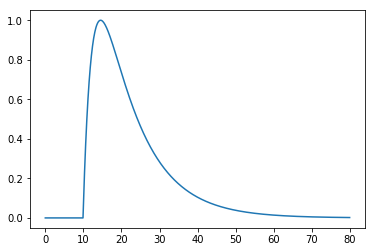

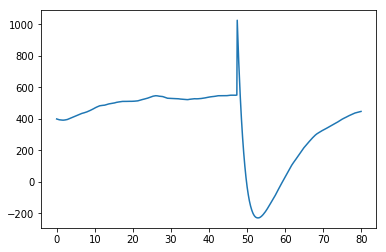

In [4]:
# Initial neuron parameters
n_post = 9

p_thr = 550.
p_rest = 0.
p_tau_m = 10.
p_tau_s = 2.5
p_spike_m = p_thr * (2-4)
p_spike_s = p_thr * 4

p_post_m = np.full(n_post, p_rest)
p_post_s = np.full(n_post, p_rest)

T_ref = 5.
K_PSP = (4**(4/3))/3
IPSP_peak = -0.25 * p_thr
IPSP = K_PSP * IPSP_peak

PSP_steps = 800
p_rec = np.zeros(PSP_steps)
dt = 1/10
for step in np.arange(PSP_steps):
    t = step/10
    if t == 10:
        p_post_m[0] =  1 * K_PSP
        p_post_s[0] = -1 * K_PSP
    
    p_dec_m = np.exp(-dt/p_tau_m)
    p_dec_s = np.exp(-dt/p_tau_s)
    p_post_m[0] *= p_dec_m 
    p_post_s[0] *= p_dec_s
    
    p_rec[step] = p_post_m[0] + p_post_s[0]
        
plt.plot(np.arange(PSP_steps)/10,p_rec)
plt.show()

p_post_m[0] = 500.
p_post_s[0] = -100.

PSP_steps = 800
p_rec = np.zeros(PSP_steps)
dt = 1/10
t_post_ref = 0
for step in np.arange(PSP_steps):
    t = step/10
        
    p_dec_m = np.exp(-dt/p_tau_m)
    p_dec_s = np.exp(-dt/p_tau_s)
    p_post_m[0] *= p_dec_m 
    p_post_s[0] *= p_dec_s
    p_rec[step] = p_post_m[0] + p_post_s[0]
    
    if (p_rec[step] >= p_thr) and (t > t_post_ref):
        t_post_ref = t + T_ref
        p_post_m[0] = p_spike_m
        p_post_s[0] = p_spike_s
        
    Dp = 2*np.random.randn() + 3.5
    p_post_m[0] +=  Dp * K_PSP
    p_post_s[0] += -Dp * K_PSP
    
plt.plot(np.arange(PSP_steps)/10,p_rec)
plt.show()

## Synapses and Spike-Timing Dependent Plasticity

The tranmission of potential across the synapse is defined in the previous section.
The synapses also have a weight, which describe the efficacy of the transmission.
The simulation being developed has excitatory connections from the presynaptic neurons to the postsynaptic neurons and lateral inhibitory connections between postsynaptic neurons.

The spike-timing-dependent plasticity (STDP) model implemented alters the weights of connections from the presynaptic neurons to the postsynaptic neurons according to the relative timing of neuron spikes. 

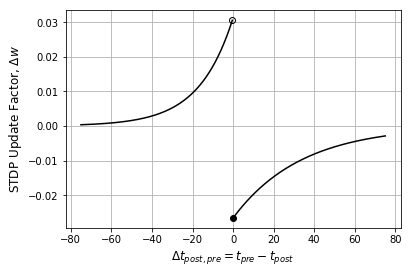

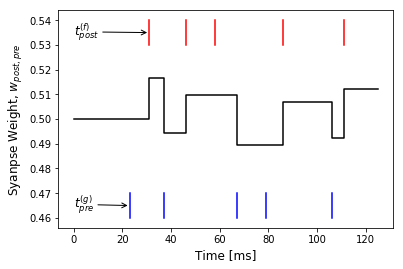

In [5]:
# Initial synapse parameters
w_min = 0.
w_max = 1.
w_inh = 1.

# STDP parameters and variables
A_p = 0.03125
A_n = 0.85 * A_p
STDP_tau_p = 16.8
STDP_tau_n = 33.7

# Plot STDP curve
Dt_p = np.linspace(-75., 0., num=200, endpoint=False)
Dt_n = np.linspace(0., 75., num=200)
STDP_curve_p = A_p * np.exp( Dt_p / STDP_tau_p )
STDP_curve_n = - A_n * np.exp( -Dt_n / STDP_tau_n )

plt.plot(Dt_p, STDP_curve_p, color='k')
plt.plot(Dt_p[-1], STDP_curve_p[-1], marker='o', markersize=6, fillstyle='none', color='k')
plt.plot(Dt_n, STDP_curve_n, color='k')
plt.plot(Dt_n[0], STDP_curve_n[0], marker='o', markersize=6, color = 'k')
plt.xlabel("$\Delta t_{post,pre}=t_{pre}-t_{post}$", fontsize=12)
plt.ylabel("STDP Update Factor, $\Delta w$", fontsize=12)
plt.grid()
plt.show()

# Demonstration of STDP
long_time = 1e6
t_f_pre_list_demo = [23, 37, 67, 79, 106, np.inf]
t_f_post_list_demo = [31, 46, 58, 86, 111, np.inf]
t_end = 125
nearest_f_pre = False
nearest_f_post = False

w_ij = 0.5
w_ij_list = [w_ij]
t_list = [0]
i_pre = 0
i_post = 0
t_f_pre = -long_time
t_f_post = -long_time
while t_f_pre_list_demo[i_pre] != np.inf or t_f_post_list_demo[i_post] != np.inf:
    if t_f_pre_list_demo[i_pre] < t_f_post_list_demo[i_post]:
        t_f_pre = t_f_pre_list_demo[i_pre]
        if nearest_f_pre:
            t_list.append(t_f_pre)
            t_list.append(t_f_pre)
            
            w_ij_list.append(w_ij)
            w_ij = w_ij - A_n * np.exp(-(t_f_pre-t_f_post)/STDP_tau_n)
            w_ij_list.append(w_ij)
        nearest_f_pre = False
        nearest_f_post = True
        i_pre += 1
    else:
        t_f_post = t_f_post_list_demo[i_post]
        if nearest_f_post:
            t_list.append(t_f_post)
            t_list.append(t_f_post)
            
            w_ij_list.append(w_ij)
            w_ij = w_ij + A_n * np.exp((t_f_pre-t_f_post)/STDP_tau_p)
            w_ij_list.append(w_ij)
        nearest_f_pre = True
        nearest_f_post = False
        i_post += 1

t_list.append(t_end)
w_ij_list.append(w_ij_list[-1])
        
t_f_post_line = [0.53,0.54]
t_f_pre_line = [0.46,0.47]

plt.plot(t_list, w_ij_list, color='k')
for f in range(len(t_f_pre_list_demo)-1):
    plt.plot(np.array(t_f_post_list_demo[f])*[1,1], t_f_post_line, color='r')
for f in range(len(t_f_post_list_demo)-1):
    plt.plot(np.array(t_f_pre_list_demo[f])*[1,1], t_f_pre_line, color='b')
    
plt.xlabel("Time [ms]", fontsize=12)
plt.ylabel("Syanpse Weight, $w_{post,pre}$", fontsize=12)
plt.annotate("$t^{(f)}_{post}$", 
             xy=(t_f_post_list_demo[0], t_f_post_line[0]+0.005),
             xytext=(0,t_f_post_line[0]+0.004), 
             fontsize=12, 
             arrowprops=dict(arrowstyle="->"))
plt.annotate("$t^{(g)}_{pre}$", 
             xy=(t_f_pre_list_demo[0], t_f_pre_line[0]+0.005),
             xytext=(0,t_f_pre_line[0]+0.004), 
             fontsize=12, 
             arrowprops=dict(arrowstyle="->"))

plt.show()


In [6]:
# Save and clear parameters and spike-time lists
import shelve
filename='./tmp/sim_parameters'
sim_param_shelf = shelve.open(filename,'c') # 'n' for new

print('Shelving variables for later simulation:')
for key in dir():
    if not key.startswith("_"):
        try:
            sim_param_shelf[key] = globals()[key]
            print(key)
        except:
            #
            # __builtins__, my_shelf, and imported modules can not be shelved.
            #
            print('ERROR shelving: {0}'.format(key))
sim_param_shelf.close()

%reset -f

Shelving variables for later simulation:
A_n
A_p
Dp
Dt_n
Dt_p
IPSP
IPSP_peak
In
K_PSP
Out
PSP_steps
STDP_curve_n
STDP_curve_p
STDP_tau_n
STDP_tau_p
T_ref
available
columns_p
columns_stl
columns_stpr
cur_pattern
dt
ERROR shelving: exit
f
f_p
f_pattern
f_r
filename
ERROR shelving: get_ipython
i_post
i_pre
long_time
n
n_pattern
n_post
n_pre
nearest_f_post
nearest_f_pre
ERROR shelving: np
p
p_dec_m
p_dec_s
p_post_m
p_post_s
p_r
p_rec
p_rest
p_spike_m
p_spike_s
p_tau_m
p_tau_s
p_thr
pattern_n
pattern_neuron_mask
pattern_repeat_n
pattern_segment_base
pattern_segment_ind
pattern_segment_list
pattern_segment_list_shape
pattern_segment_next
pattern_seq
ERROR shelving: plt
ERROR shelving: quit
r_max
r_min
r_noise
rate
rate_d
rd_max
rd_min
rdd
rdd_max
rdd_min
repeat_n
segment_available
segment_n
segment_select
segment_steps
segment_time
ERROR shelving: shelve
sim_param_shelf
sim_segment
sim_step
sim_time
spike_num
spike_plot
spike_plot_neurons
spike_plot_time
spike_times_list
spike_times_list_cou

## Simulation with STDP and Lateral Inhibition

An earlier study (Masquelier et al., 2009) examined the ability of STDP with lateral inhibition to produce competitively tuned neurons that detect hidden spike patterns.
A short period of input spike activity based on this earlier study has been produced.
The code below simulates a set of postsynaptic neurons and then their activity is investigated.

First, the presynaptic neuron activity (with concealed repeating patterns) and postsynaptic neuron parameters are loaded from the earlier section. 

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import shelve

filename = './tmp/sim_parameters'
sim_param_shelf = shelve.open(filename) # 'n' for new

spike_times_list = sim_param_shelf['spike_times_list']

A_p = sim_param_shelf['A_p']
A_n = sim_param_shelf['A_n']
IPSP = sim_param_shelf['IPSP']
K_PSP = sim_param_shelf['K_PSP']
long_time = sim_param_shelf['long_time']
n_pre = sim_param_shelf['n_pre']
p_rest = sim_param_shelf['p_rest']
p_spike_m = sim_param_shelf['p_spike_m']
p_spike_s = sim_param_shelf['p_spike_s']
p_tau_m = sim_param_shelf['p_tau_m']
p_tau_s = sim_param_shelf['p_tau_s']
p_thr = sim_param_shelf['p_thr']
sim_time = sim_param_shelf['sim_time']
STDP_tau_p = sim_param_shelf['STDP_tau_p']
STDP_tau_n = sim_param_shelf['STDP_tau_n']
T_ref = sim_param_shelf['T_ref']
w_inh = sim_param_shelf['w_inh']
w_min = sim_param_shelf['w_min']
w_max = sim_param_shelf['w_max']

sim_param_shelf.close()

print("Simulation time: " + str(sim_time/1000) + " seconds")
print("Shape of spike_times_list: " + str(spike_times_list.shape))

Simulation time: 67.5 seconds
Shape of spike_times_list: (2000, 13500)


The simulation of postsynaptic neuron activity and synaptic plasticity can be performed now. 
(On a quadcore i5-3570K CPU @ 3.40GHz, 16GB RAM, 3 seconds of simulated time takes about 1 minute: total run-time is around 20 minutes.)

In [8]:
n_post = 9

# reset postsynaptic potential variables
p_post_m = np.full(n_post, p_rest)
p_post_s = np.full(n_post, p_rest)

# Initial synapse variables
w_IJ = np.random.rand(n_pre,n_post)
nearest_f_pre = np.full((n_pre,n_post), False)
nearest_f_post = np.full((n_pre,n_post), True)

# Recording and tracking neuron spike times
t_f_post_list_max = int(200 + sim_time / 500)
t_f_post_list = np.full((n_post,t_f_post_list_max), np.inf)
t_f_post_list_count = np.zeros((n_post), dtype='int')

t_post_ref = np.full((n_post),-long_time)
t_f_post = np.full((n_post),-long_time)
t_f_pre = np.full((n_pre),-long_time)
t_f_pre_list_temp = spike_times_list[:,0].copy()
t_f_pre_list_count = np.zeros(n_pre, dtype='int')

t_display_next = 0
t_display_inc = 500
t = np.amin(t_f_pre_list_temp)

# Simulation loop
count_depression_updates = np.zeros(n_post, dtype='int')
count_potentiation_updates = np.zeros(n_post, dtype='int')
while any(np.not_equal(t_f_pre_list_temp, np.inf)):
    # find next presynaptic spike-time (event driven simulation)
    dt = np.amin(t_f_pre_list_temp) - t
    t = np.amin(t_f_pre_list_temp)
    n_f_pre = np.argwhere(t_f_pre_list_temp == t)
    
    if t >= t_display_next:
        print('Simulated time elapsed: ' + str(t_display_next/1000) + '/' + str(sim_time/1000) + 's')
        t_display_next += t_display_inc
        print('Spike counts: ' + str(t_f_post_list_count))
    
    # neuron potential variables decay according to time constants
    p_dec_m = np.exp(-dt/p_tau_m)
    p_dec_s = np.exp(-dt/p_tau_s)
    p_post_m *= p_dec_m 
    p_post_s *= p_dec_s
        
    # find postsynaptic spikes
    not_ref = t > t_post_ref
    f_post = ((p_post_m + p_post_s) > p_thr) & not_ref
    if any(f_post): # if a postsynaptic neuron spikes
        # inhibit other neurons
        p_post_m[~f_post] += IPSP*w_inh
        p_post_s[~f_post] -= IPSP*w_inh
        # set neuron potentials for spikes
        p_post_m[f_post] = p_spike_m
        p_post_s[f_post] = p_spike_s
        # update refractory time
        t_post_ref[f_post] = t + T_ref
        # record spike times
        t_f_post[f_post] = t
        t_f_post_list[f_post, t_f_post_list_count[f_post]] = t 
        t_f_post_list_count[f_post] += 1
        
    # STDP: potentiate connections of active postsynaptic neurons
    for n in np.argwhere(f_post):
        Dt_f_ij = t - t_f_pre[nearest_f_post[:,n].flatten()]
        Dw = A_p * np.exp(-Dt_f_ij/STDP_tau_p)
        w_IJ[nearest_f_post[:,n].flatten(),n] = np.minimum(w_max, w_IJ[nearest_f_post[:,n].flatten(),n] + Dw)
        nearest_f_pre[:,n] = True
        nearest_f_post[:,n] = False
    
    # STDP: depress connections of active presynaptic neurons
    for n in n_f_pre:
        for p in np.argwhere(nearest_f_pre[n,:].flatten()):
            Dt_f_ij = t_f_post[p] - t
            Dw = -A_n * np.exp(Dt_f_ij/STDP_tau_n)
            w_IJ[n,p] = np.maximum(w_min, w_IJ[n,p] + Dw)
        nearest_f_pre[n,:] = False
        nearest_f_post[n,:] = True
    
    Dp = K_PSP * np.sum(w_IJ[n_f_pre,:],axis=0)
    p_post_m += Dp.flatten()
    p_post_s -= Dp.flatten()
    
    t_f_pre[n_f_pre] = t
    t_f_pre_list_count[n_f_pre] += 1
    t_f_pre_list_temp[n_f_pre] = spike_times_list[n_f_pre,t_f_pre_list_count[n_f_pre]].copy()
    
print('Simulated time elapsed: ' + str(sim_time/1000) + '/' + str(sim_time/1000) + 's')
print('Simulation complete')

Simulated time elapsed: 0.0/67.5s
Spike counts: [0 0 0 0 0 0 0 0 0]
Simulated time elapsed: 0.5/67.5s
Spike counts: [12 10 11 11 12 13 12 12 12]
Simulated time elapsed: 1.0/67.5s
Spike counts: [23 21 21 22 23 26 22 23 23]
Simulated time elapsed: 1.5/67.5s
Spike counts: [33 31 31 31 33 37 32 35 32]
Simulated time elapsed: 2.0/67.5s
Spike counts: [42 41 40 40 43 48 41 45 41]
Simulated time elapsed: 2.5/67.5s
Spike counts: [52 50 46 49 51 57 50 55 51]
Simulated time elapsed: 3.0/67.5s
Spike counts: [60 58 56 56 59 65 57 65 56]
Simulated time elapsed: 3.5/67.5s
Spike counts: [68 66 63 64 67 72 64 71 65]
Simulated time elapsed: 4.0/67.5s
Spike counts: [73 73 70 70 74 78 73 79 74]
Simulated time elapsed: 4.5/67.5s
Spike counts: [79 80 77 76 79 87 82 85 81]
Simulated time elapsed: 5.0/67.5s
Spike counts: [87 85 81 84 85 94 86 91 88]
Simulated time elapsed: 5.5/67.5s
Spike counts: [92 92 88 90 89 99 92 98 94]
Simulated time elapsed: 6.0/67.5s
Spike counts: [ 99 100  95  95  95 105  97 103  97]

Simulated time elapsed: 48.0/67.5s
Spike counts: [166 220 228 227 193 192 213 231 239]
Simulated time elapsed: 48.5/67.5s
Spike counts: [166 220 231 227 193 193 214 234 239]
Simulated time elapsed: 49.0/67.5s
Spike counts: [166 221 232 228 193 193 214 235 240]
Simulated time elapsed: 49.5/67.5s
Spike counts: [166 222 234 229 194 193 215 237 241]
Simulated time elapsed: 50.0/67.5s
Spike counts: [166 224 235 231 196 193 217 237 243]
Simulated time elapsed: 50.5/67.5s
Spike counts: [166 225 237 232 197 193 218 239 244]
Simulated time elapsed: 51.0/67.5s
Spike counts: [166 226 239 233 199 193 220 240 245]
Simulated time elapsed: 51.5/67.5s
Spike counts: [166 226 239 233 202 193 223 240 245]
Simulated time elapsed: 52.0/67.5s
Spike counts: [166 226 241 233 203 194 223 242 245]
Simulated time elapsed: 52.5/67.5s
Spike counts: [166 227 243 234 203 194 223 244 246]
Simulated time elapsed: 53.0/67.5s
Spike counts: [166 229 244 236 205 194 225 245 248]
Simulated time elapsed: 53.5/67.5s
Spike co

In [9]:
import shelve
filename='./tmp/sim_stdp'
sim_stdp_shelf = shelve.open(filename,'c') # 'n' for new

%reset_selective -f spike_times_list 

print('Shelving variables for later reference:')
for key in dir():
    if not key.startswith("_"):
        try:
            sim_stdp_shelf[key] = globals()[key]
            print(key)
        except:
            #
            # __builtins__, my_shelf, and imported modules can not be shelved.
            #
            print('ERROR shelving: {0}'.format(key))
sim_stdp_shelf.close()

%reset -f

Shelving variables for later reference:
A_n
A_p
Dp
Dt_f_ij
Dw
IPSP
In
K_PSP
Out
STDP_tau_n
STDP_tau_p
T_ref
count_depression_updates
count_potentiation_updates
dt
ERROR shelving: exit
f_post
filename
ERROR shelving: get_ipython
long_time
n
n_f_pre
n_post
n_pre
nearest_f_post
nearest_f_pre
not_ref
ERROR shelving: np
p
p_dec_m
p_dec_s
p_post_m
p_post_s
p_rest
p_spike_m
p_spike_s
p_tau_m
p_tau_s
p_thr
ERROR shelving: plt
ERROR shelving: quit
ERROR shelving: shelve
sim_param_shelf
sim_stdp_shelf
sim_time
t
t_display_inc
t_display_next
t_f_post
t_f_post_list
t_f_post_list_count
t_f_post_list_max
t_f_pre
t_f_pre_list_count
t_f_pre_list_temp
t_post_ref
w_IJ
w_inh
w_max
w_min


### Postsynaptic Neuron Activity

Once the simulation has been completed and the postsynaptic neuron spike times have been recorded, the activity of the postsynaptic neurons can be examined.
The first plot shows the rate of postsynaptic neuron activity over time.
All of the postsynaptic neurons respond randomly at first and spike regularly.
The spike-timing-dependent plasticity rule gradually decreases the overall input weight to the postsynaptic neurons and the neurons either become selectively responsive to a small set of active neurons (the neurons in a hidden pattern) or become unresponsive.

The next set of plots show the latency of the postsynaptic neurons to the repetitions of hidden patterns.
Each repetition of a pattern lasts for 50ms, postsynaptic spikes that do not occur inside any repetition of a hidden pattern are presented as having a latency of 0ms.
Neurons typically have an initial period of spiking randomly inside and outside the repetitions of a spike pattern.
Then the postsynaptic neuron either tunes to a set of neurons that are active in one of the repeating spike patterns and have a consistent latency for that spike pattern or the postsynaptic neuron ceases to respond.

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import shelve

filename = './tmp/sim_parameters'
sim_param_shelf = shelve.open(filename) # 'n' for new

pattern_n = sim_param_shelf['pattern_n']
pattern_segment_ind = sim_param_shelf['pattern_segment_ind']
pattern_repeat_n = sim_param_shelf['pattern_repeat_n']
segment_time = sim_param_shelf['segment_time']

sim_param_shelf.close()

filename='./tmp/sim_stdp'
sim_stdp_shelf = shelve.open(filename) # 'n' for new

n_post = sim_stdp_shelf['n_post']
t_f_post_list = sim_stdp_shelf['t_f_post_list']
t_f_post_list_count = sim_stdp_shelf['t_f_post_list_count']

sim_stdp_shelf.close()

print("Shape of spike_times_list: " + str(t_f_post_list.shape))

Shape of spike_times_list: (9, 335)


Display postsynatpic spike trains


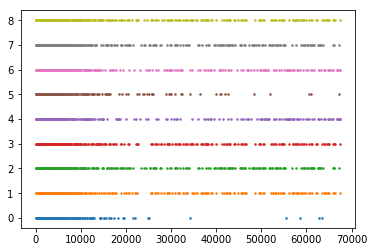

Display postsynaptic neuron spike latencies relative to pattern repetitions


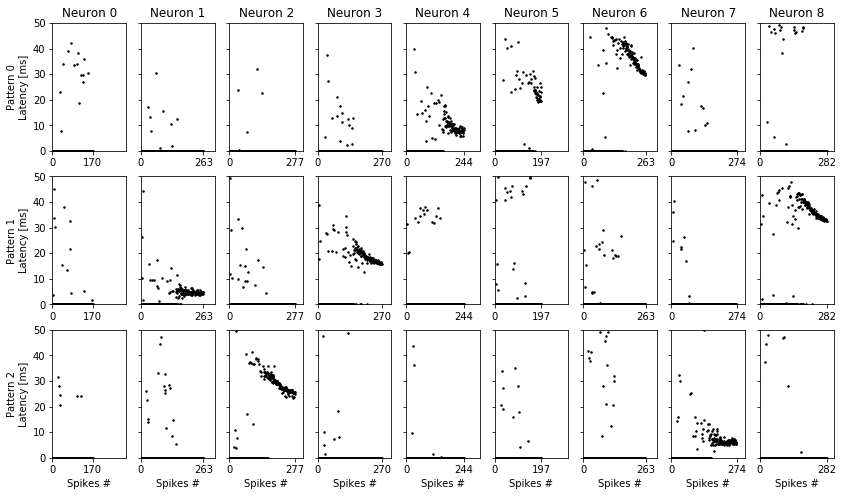

In [11]:
print('Display postsynatpic spike trains')
for n in range(n_post):
    plt.plot(t_f_post_list[n,range(t_f_post_list_count[n])],
             np.full((t_f_post_list_count[n]), n),
             '.', markersize=3)
plt.show()

print('Display postsynaptic neuron spike latencies relative to pattern repetitions')
subp_i = 0;
fig = plt.figure(figsize = (14,8))
fig.subplots(nrows=pattern_n,ncols=n_post)
for p in range(pattern_n):
    for n in range(n_post):
        t_post_latency = np.zeros(t_f_post_list_count[n])
        p_rep = 0
        for f in range(t_f_post_list_count[n]):
            while t_f_post_list[n,f] > ((pattern_segment_ind[p_rep,p]+1)*segment_time):
                if p_rep < pattern_repeat_n-1:
                    p_rep += 1
                else:
                    break
            tpl = t_f_post_list[n,f] - (pattern_segment_ind[p_rep,p]*segment_time)
            if tpl > 0 and tpl < segment_time:
                t_post_latency[f] = tpl
        #print('Neuron: ' + str(n) + '; Pattern: ' + str(p))
        subp_i += 1
        plt.subplot(pattern_n, n_post, subp_i)
        plt.plot(np.arange(t_f_post_list_count[n]), t_post_latency, 'k.', markersize=3)
        plt.ylim((0,50))
        plt.xlim((0,np.amax(t_f_post_list_count)*1.1))
        plt.xticks([0, t_f_post_list_count[n]])
        if p == 0:
            plt.title('Neuron ' + str(n))
        if p == pattern_n-1:
            plt.xlabel('Spikes #')
        if n != 0:
            locs, labels = plt.yticks()
            plt.yticks(locs, {})
        else:
            plt.ylabel('Pattern ' + str(p) + '\nLatency [ms]')

plt.show()

## Simulation of STDP with Neuron Construction

The first simulation of postsynaptic neurons initialised 9 neurons with random synapse weights then the activity of the presynaptic and postsynaptic neurons combined with STDP resulted in the neurons tuning to spike patterns concealed within the presynaptic activity.
The next simulation will construct postsynaptic neurons in one shot with synapse weights selected using a prediction of the convergence of STDP for those relative spike times.

The initial number of neurons simulated will be zero.
Because there is a consistently high rate of neuron activity in the presynaptic activity, a simple way to detect whether the activity contains a repeating pattern from a single observation is not obvious.
Therefore, postsynaptic neurons will be constructed every 15ms or 15ms after the last postsynaptic neuron spike.
A spike from a simulated postsynaptic neuron within 15ms of the construction of a postsynaptic neuron will cancel that neuron construction.
A neuron that is constructed and does not spike at a least a rate of 1Hz in the first 5s of simulation is also considered insufficiently tuned to a pattern or insignificant and is pruned.

Additive models of STDP have a tendency to produce synapse weights that are clustered near the minimum and maximum values.
Constructed neurons have the synapses from the most recent presynaptic neurons to spike potentiated to the maximum value while all other synapses are depressed to the minimum value.
An initial total input weight of 450 has been found in earlier experiments to reliably produce neurons that are selective to patterns in presynpatic activity.

In [12]:
%reset -f
import matplotlib.pyplot as plt
import numpy as np
import shelve

filename = './tmp/sim_parameters'
sim_param_shelf = shelve.open(filename) # 'n' for new

spike_times_list = sim_param_shelf['spike_times_list']

A_p = sim_param_shelf['A_p']
A_n = sim_param_shelf['A_n']
IPSP = sim_param_shelf['IPSP']
K_PSP = sim_param_shelf['K_PSP']
long_time = sim_param_shelf['long_time']
n_pre = sim_param_shelf['n_pre']
p_rest = sim_param_shelf['p_rest']
p_spike_m = sim_param_shelf['p_spike_m']
p_spike_s = sim_param_shelf['p_spike_s']
p_tau_m = sim_param_shelf['p_tau_m']
p_tau_s = sim_param_shelf['p_tau_s']
p_thr = sim_param_shelf['p_thr']
sim_time = sim_param_shelf['sim_time']
STDP_tau_p = sim_param_shelf['STDP_tau_p']
STDP_tau_n = sim_param_shelf['STDP_tau_n']
T_ref = sim_param_shelf['T_ref']
w_inh = sim_param_shelf['w_inh']
w_min = sim_param_shelf['w_min']
w_max = sim_param_shelf['w_max']

sim_param_shelf.close()

print("Simulation time: " + str(sim_time/1000) + " seconds")
print("Shape of spike_times_list: " + str(spike_times_list.shape))

Simulation time: 67.5 seconds
Shape of spike_times_list: (2000, 13500)


In [13]:
# neuron construction parameters
n_select = 450
n_post_max = 80
nps = np.full((n_post_max), False)   # A logical vector to indicate which neurons are currently simulated
T_cancel = 15                        # A constructed neuron is cancelled if another postsynaptic neurons spikes in 15ms
t_cancel = -long_time                # The cancellation time for the last constructed neuron
T_prune = 5000                       # A neuron is pruned if it doesn't meet minimum activity criterion in 5s
f_min = 5                            # The minimum activity criterion is 5 spikes in the first 5 seconds
t_prune_ind = []                     # A list of the neurons that have not passed the pruning criterion 
t_prune = []                         # A list of the pruning times for neurons that have been constructed

# postsynaptic neuron variables
n_post = 0
p_post_m = np.full(n_post_max, p_rest)
p_post_s = np.full(n_post_max, p_rest)

# proxy postsynaptic neuron variables
n_proxy = 1
p_proxy_m = np.full(n_proxy, p_rest)
p_proxy_s = np.full(n_proxy, p_rest)

# Initial synapse variables
w_IJ = np.full((n_pre,n_post_max), 0.)
w_proxyJ = 0.5

# STDP variables
nearest_f_pre = np.full((n_pre,n_post_max), False)
nearest_f_post = np.full((n_pre,n_post_max), True)

# Recording and tracking neuron spike times
t_f_post_list_max = int(200 + sim_time / 500)
t_f_post_list = np.full((n_post_max,t_f_post_list_max), np.inf)
t_f_post_list_count = np.zeros(n_post_max, dtype='int')

t_f_proxy_list_max = t_f_post_list_max
t_f_proxy_list = np.full(t_f_proxy_list_max, np.inf)
t_f_proxy_list_count = 0

t_post_ref = np.full(n_post_max,-long_time)
t_proxy_ref = -long_time
t_f_post = np.full(n_post_max,-long_time)
t_f_pre = np.full(n_pre,-long_time)
t_f_pre_list_temp = spike_times_list[:,0].copy()
t_f_pre_list_count = np.zeros(n_pre, dtype='int')

t_display_next = 0
t_display_inc = 500
t = np.amin(t_f_pre_list_temp)

# Simulation loop
while any(np.not_equal(t_f_pre_list_temp, np.inf)):
    # find next presynaptic spike-time (event driven simulation)
    dt = np.amin(t_f_pre_list_temp) - t
    t = np.amin(t_f_pre_list_temp)
    n_f_pre = np.argwhere(t_f_pre_list_temp == t)
    
    if t >= t_display_next:
        print('Simulated time elapsed: ' + str(t_display_next/1000) + '/' + str(sim_time/1000) + 's')
        t_display_next += t_display_inc
        print('Simulated postsynaptic neuron spike counts:\n' + str(t_f_post_list_count[nps]))
        #print("w_IJ[:,nps]: " +str(w_IJ[:,nps]))
        #print("np.argwhere(w_IJ[:,0]): " + str(np.argwhere(w_IJ[:,0])))
        
    
    # check provisional neurons for removal
    #print("t_prune: " + str(t_prune))
    
    if any(t_prune) and t > t_prune[0]:
        print("pruning neuron: " + str(t_prune_ind[0]))
        nps[t_prune_ind[0]] = False
        t_prune.pop(0)
        t_prune_ind.pop(0)            
    
    # neuron potential variables decay according to time constants
    p_dec_m = np.exp(-dt/p_tau_m)
    p_dec_s = np.exp(-dt/p_tau_s)
    p_post_m[nps] *= p_dec_m 
    p_post_s[nps] *= p_dec_s
    p_proxy_m *= p_dec_m
    p_proxy_s *= p_dec_s
        
    #if nps[0]:
        #print("p_post_m[0] = " + str(p_post_m[0]))
        #print("nps[0]=" + str(nps[0]))
        
    # detect postsynaptic spikes
    not_ref = t > t_post_ref
    f_post_bool = np.logical_and(((p_post_m + p_post_s) > p_thr), not_ref)
    f_post_ind = np.argwhere(f_post_bool)
    #print("f_post: " + str(f_post))        
    if np.any(f_post_bool): # if a postsynaptic neuron spikes
        # inhibit other simulated postsynaptic neurons
        p_post_m[np.logical_and(~f_post_bool,nps)] += IPSP*w_inh*np.sum(f_post_bool)
        p_post_s[np.logical_and(~f_post_bool,nps)] -= IPSP*w_inh*np.sum(f_post_bool)
        
        # set neuron potentials for spikes
        p_post_m[f_post_ind] = p_spike_m
        p_post_s[f_post_ind] = p_spike_s
        
        # update refractory time
        t_post_ref[f_post_ind] = t + T_ref
        
        # record spike times
        t_f_post[f_post_ind] = t
        t_f_post_list[f_post_ind, t_f_post_list_count[f_post_ind]] = t 
        t_f_post_list_count[f_post_ind] += 1
        
        # inhibit proxy neuron
        p_proxy_m += IPSP*w_inh*np.sum(f_post_bool)
        p_proxy_s -= IPSP*w_inh*np.sum(f_post_bool)
        t_proxy_ref = t + T_cancel
        
        # check for neuron cancellation
        # print("f_post_bool[0:-1] = " + str(f_post_bool[0:-1]))
        if t < t_cancel and np.any(f_post_bool[0:-2]):
            n_post -= 1
            nps[n_post] = False
            w_IJ[:,n_post] = 0
            p_post_m[n_post] = 0
            p_post_s[n_post] = 0
            t_f_post[n_post] = 0
            t_f_post_list[n_post,:] = 0
            t_f_post_list_count[n_post] = 0
            t_cancel = -long_time
            t_prune.pop()
            t_prune_ind.pop()
            f_post_bool[n_post] = False
            f_post_ind = np.argwhere(f_post_bool)
        
        # check for neurons that meet minimum activity criterion to avoid pruning 
        if t_f_post_list_count[f_post_ind] > f_min:
            for ind in range(len(t_prune_ind)):
                if t_prune_ind[ind] == f_post_ind:
                    t_prune_ind.pop(ind)
                    t_prune.pop(ind)
                    break                 
    
    # if proxy postsynaptic neuron spikes then construct a neuron
    if (p_proxy_m + p_proxy_s) > p_thr and t > t_proxy_ref and n_post < n_post_max:
        #print("time: " + str(t) + "; t_proxy_ref: " + str(t_proxy_ref) )
        # update proxy neuron
        p_proxy_m = p_spike_m
        p_proxy_s = p_spike_s
        t_proxy_ref = t + T_cancel
        
        t_f_proxy_list[t_f_proxy_list_count] = t 
        t_f_proxy_list_count += 1
        
        # construct a postsynaptic neuron
        nps[n_post] = True
        n_recent = np.argsort(-t_f_pre)
        w_IJ[n_recent[0:n_select].flatten(),n_post] = w_max

        #print("sorted t_f_pre: " + str(t_f_pre[n_recent]))
        #print("n_recent[0:n_select] = " + str(n_recent[0:n_select]))
        #print("sum w_IJ[:,n_post] = " + str(np.sum(w_IJ[:,n_post])))
        #print("np.argwhere(w_IJ[:,n_post]): " + str(np.argwhere(w_IJ[:,n_post])))
        
        nearest_f_pre[:,n_post] = True
        nearest_f_post[:,n_post] = False
        
        t_f_post[n_post] = t
        t_f_post_list[n_post,0] = t
        t_f_post_list_count[n_post] = 1
        t_cancel = t + T_cancel
        t_prune.append(t + T_prune)
        t_prune_ind.append(n_post)
        n_post += 1
        
        #print("np.argwhere(w_IJ[:,0]): " + str(np.argwhere(w_IJ[:,0])))
        #print("sum w_IJ[:,0] = " + str(np.sum(w_IJ[:,0])))
    
    # STDP: potentiate connections of active postsynaptic neurons
    for n in f_post_ind:
        Dt_f_ij = t - t_f_pre[nearest_f_post[:,n].flatten()]
        Dw = A_p * np.exp(-Dt_f_ij/STDP_tau_p)
        w_IJ[nearest_f_post[:,n].flatten(),n] = np.minimum(w_max, w_IJ[nearest_f_post[:,n].flatten(),n] + Dw)
        nearest_f_pre[:,n] = True
        nearest_f_post[:,n] = False
    
    # STDP: depress connections of active presynaptic neurons
    for n in n_f_pre:
        for p in np.argwhere(nearest_f_pre[n,:].flatten()):
            Dt_f_ij = t_f_post[p] - t
            Dw = -A_n * np.exp(Dt_f_ij/STDP_tau_n)
            #print("before, w_IJ[n,p] = " + str(w_IJ[n,p]))
            w_IJ[n,p] = np.maximum(w_min, w_IJ[n,p] + Dw)
            
            #print("t_f_post[p] = " + str(t_f_post[p]))
            #print("n: " + str(n) + "; Dt_f_ij = " + str(Dt_f_ij))
            #print("n: " + str(n) + "; p: " + str(p))
            #print("Dw = " + str(Dw) + "; w_IJ[n,p] = " + str(w_IJ[n,p]))
            #print("np.maximum(w_min, w_IJ[n,p] + Dw) = " + str(np.maximum(w_min, w_IJ[n,p] + Dw)))
            #print("w_IJ[n,p] = " + str(w_IJ[n,p]))
            
        nearest_f_pre[n,:] = False
        nearest_f_post[n,:] = True
        
        #print("sum w_IJ[:,0] = " + str(np.sum(w_IJ[:,0])))
        #print("Dw = " + str(Dw))
    
    #print("n_f_pre: " + str(n_f_pre))
    #if np.any(w_IJ[n_f_pre,nps]):
    #    print("np.sum(w_IJ[n_f_pre,nps],axis=0) = " + str(np.sum(w_IJ[n_f_pre,nps],axis=0)))
    
    Dp = K_PSP * np.sum(w_IJ[n_f_pre,nps],axis=0)
    p_post_m[nps] += Dp.flatten()
    p_post_s[nps] -= Dp.flatten()
    
    #if np.any(Dp > 0):
    #    print("Dp = " + str(Dp))
    
    p_proxy_m += K_PSP * w_proxyJ * n_f_pre.size
    p_proxy_s -= K_PSP * w_proxyJ * n_f_pre.size
    
    t_f_pre[n_f_pre] = t
    t_f_pre_list_count[n_f_pre] += 1
    t_f_pre_list_temp[n_f_pre] = spike_times_list[n_f_pre,t_f_pre_list_count[n_f_pre]].copy()
    
print('Simulated time elapsed: ' + str(sim_time/1000) + '/' + str(sim_time/1000) + 's')
print('Simulation complete')


Simulated time elapsed: 0.0/67.5s
Simulated postsynaptic neuron spike counts:
[]
Simulated time elapsed: 0.5/67.5s
Simulated postsynaptic neuron spike counts:
[1 1 3 1 1 1 2 1 1 2 3 2 1 2 2 1 2 1 1]
Simulated time elapsed: 1.0/67.5s
Simulated postsynaptic neuron spike counts:
[1 1 3 1 1 1 2 1 1 3 4 3 1 2 2 1 2 1 1 1 2 2 2 2 1 2 3 1 1 1 1 1 2 2 1 1 1]
Simulated time elapsed: 1.5/67.5s
Simulated postsynaptic neuron spike counts:
[1 1 3 1 1 1 2 1 1 3 4 3 1 2 2 1 2 1 1 1 2 2 2 2 1 2 3 1 1 1 1 1 2 2 1 1 1
 3 3 3 2 1 3 2 1 1 1 1 1 1 1 1 1 1 1]
Simulated time elapsed: 2.0/67.5s
Simulated postsynaptic neuron spike counts:
[1 1 3 1 1 1 2 1 1 5 6 5 1 2 2 1 2 1 1 1 2 2 2 2 1 2 3 1 1 1 1 1 2 2 1 1 1
 4 4 4 2 1 3 2 1 1 1 1 1 2 2 2 1 1 2 2 1 1 1 2 1 1 1 1 2 1 2 1]
Simulated time elapsed: 2.5/67.5s
Simulated postsynaptic neuron spike counts:
[1 1 3 1 1 1 2 1 1 6 7 6 1 2 2 1 2 1 1 1 2 2 2 2 1 2 3 1 1 1 1 1 2 2 1 1 1
 4 4 4 2 1 3 2 1 1 1 1 1 3 3 2 1 1 2 2 1 1 1 2 1 1 1 1 2 1 2 2 1 2 2 1 2 1
 2 1 1 1 2 

Simulated time elapsed: 24.5/67.5s
Simulated postsynaptic neuron spike counts:
[54 55 53 48 48 48 49 50 44]
Simulated time elapsed: 25.0/67.5s
Simulated postsynaptic neuron spike counts:
[54 55 53 48 48 48 51 52 46]
Simulated time elapsed: 25.5/67.5s
Simulated postsynaptic neuron spike counts:
[55 56 54 50 51 51 52 53 47]
Simulated time elapsed: 26.0/67.5s
Simulated postsynaptic neuron spike counts:
[57 58 56 51 52 52 54 55 49]
Simulated time elapsed: 26.5/67.5s
Simulated postsynaptic neuron spike counts:
[58 59 57 53 54 54 55 56 50]
Simulated time elapsed: 27.0/67.5s
Simulated postsynaptic neuron spike counts:
[59 60 58 54 55 55 56 57 51]
Simulated time elapsed: 27.5/67.5s
Simulated postsynaptic neuron spike counts:
[60 61 59 54 55 55 57 58 52]
Simulated time elapsed: 28.0/67.5s
Simulated postsynaptic neuron spike counts:
[61 62 60 56 57 57 57 58 52]
Simulated time elapsed: 28.5/67.5s
Simulated postsynaptic neuron spike counts:
[61 62 60 56 57 57 57 58 52]
Simulated time elapsed: 29.0

Simulated time elapsed: 61.0/67.5s
Simulated postsynaptic neuron spike counts:
[138 145 141 134 145 152 132 148 127]
Simulated time elapsed: 61.5/67.5s
Simulated postsynaptic neuron spike counts:
[139 146 142 137 148 155 133 149 128]
Simulated time elapsed: 62.0/67.5s
Simulated postsynaptic neuron spike counts:
[139 147 142 139 150 157 134 150 129]
Simulated time elapsed: 62.5/67.5s
Simulated postsynaptic neuron spike counts:
[141 149 144 140 151 158 134 150 129]
Simulated time elapsed: 63.0/67.5s
Simulated postsynaptic neuron spike counts:
[141 149 144 142 154 160 136 152 131]
Simulated time elapsed: 63.5/67.5s
Simulated postsynaptic neuron spike counts:
[142 150 145 144 156 162 137 153 132]
Simulated time elapsed: 64.0/67.5s
Simulated postsynaptic neuron spike counts:
[143 151 146 144 158 163 138 154 133]
Simulated time elapsed: 64.5/67.5s
Simulated postsynaptic neuron spike counts:
[144 152 147 144 158 164 139 155 134]
Simulated time elapsed: 65.0/67.5s
Simulated postsynaptic neuron

In [14]:
import shelve
filename='./tmp/sim_stdc'
sim_stdc_shelf = shelve.open(filename,'c') # 'n' for new

%reset_selective -f spike_times_list

print('Shelving variables for later simulation:')
for key in dir():
    if not key.startswith("_"):
        try:
            sim_stdc_shelf[key] = globals()[key]
            print(key)
        except:
            #
            # __builtins__, my_shelf, and imported modules can not be shelved.
            #
            print('ERROR shelving: {0}'.format(key))
sim_stdc_shelf.close()

%reset -f

Shelving variables for later simulation:
A_n
A_p
Dp
Dt_f_ij
Dw
IPSP
In
K_PSP
Out
STDP_tau_n
STDP_tau_p
T_cancel
T_prune
T_ref
dt
ERROR shelving: exit
f_min
f_post_bool
f_post_ind
filename
ERROR shelving: get_ipython
ind
long_time
n
n_f_pre
n_post
n_post_max
n_pre
n_proxy
n_recent
n_select
nearest_f_post
nearest_f_pre
not_ref
ERROR shelving: np
nps
p
p_dec_m
p_dec_s
p_post_m
p_post_s
p_proxy_m
p_proxy_s
p_rest
p_spike_m
p_spike_s
p_tau_m
p_tau_s
p_thr
ERROR shelving: plt
ERROR shelving: quit
ERROR shelving: shelve
sim_param_shelf
sim_stdc_shelf
sim_time
t
t_cancel
t_display_inc
t_display_next
t_f_post
t_f_post_list
t_f_post_list_count
t_f_post_list_max
t_f_pre
t_f_pre_list_count
t_f_pre_list_temp
t_f_proxy_list
t_f_proxy_list_count
t_f_proxy_list_max
t_post_ref
t_proxy_ref
t_prune
t_prune_ind
w_IJ
w_inh
w_max
w_min
w_proxyJ


In [15]:
import matplotlib.pyplot as plt
import numpy as np
import shelve

filename = './tmp/sim_parameters'
sim_param_shelf = shelve.open(filename) # 'n' for new

pattern_n = sim_param_shelf['pattern_n']
pattern_segment_ind = sim_param_shelf['pattern_segment_ind']
pattern_repeat_n = sim_param_shelf['pattern_repeat_n']
segment_time = sim_param_shelf['segment_time']

sim_param_shelf.close()

filename='./tmp/sim_stdc'
sim_stdc_shelf = shelve.open(filename) # 'n' for new

n_post = sim_stdc_shelf['n_post']
nps = sim_stdc_shelf['nps']
t_f_post_list = sim_stdc_shelf['t_f_post_list']
t_f_post_list_count = sim_stdc_shelf['t_f_post_list_count']

n_post_sim = np.sum(nps)
npi = np.argwhere(nps).flatten()

sim_stdc_shelf.close()

print("Shape of spike_times_list: " + str(t_f_post_list.shape))
print('n_post_sim: ' + str(n_post_sim))
print('n_post indices (npi): ' + str(npi))

Shape of spike_times_list: (80, 335)
n_post_sim: 9
n_post indices (npi): [ 9 10 11 37 38 39 49 50 75]


Display postsynatpic spike trains


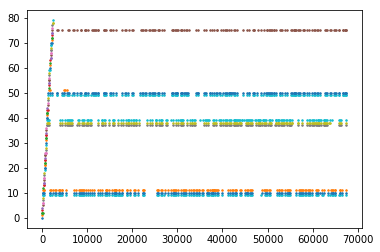

Display postsynaptic neuron spike latencies relative to pattern repetitions


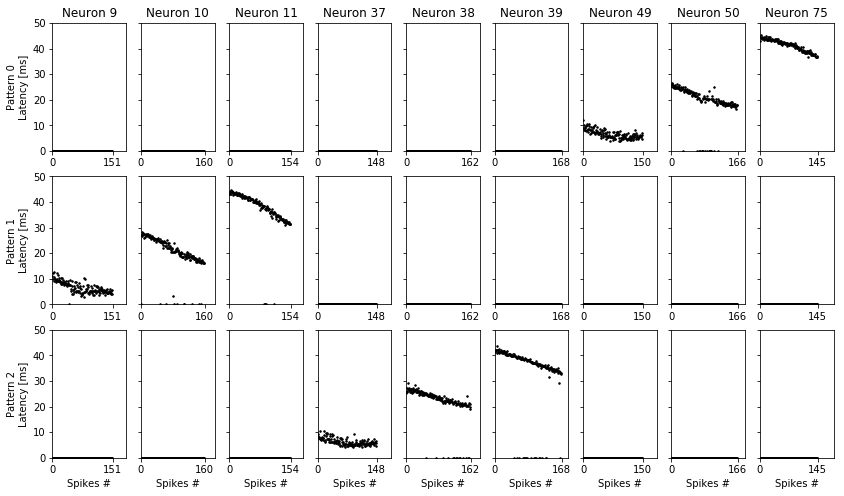

In [16]:
print('Display postsynatpic spike trains')
for n in range(n_post):
    plt.plot(t_f_post_list[n,range(t_f_post_list_count[n])],
             np.full((t_f_post_list_count[n]), n),
             '.', markersize=3)
plt.show()

print('Display postsynaptic neuron spike latencies relative to pattern repetitions')
subp_i = 0;
fig = plt.figure(figsize = (14,8))
fig.subplots(nrows=pattern_n,ncols=n_post_sim)
for p in range(pattern_n):
    for n in range(n_post_sim):
        t_post_latency = np.zeros(t_f_post_list_count[npi[n]])
        p_rep = 0
        for f in range(t_f_post_list_count[npi[n]]):
            while t_f_post_list[npi[n],f] > ((pattern_segment_ind[p_rep,p]+1)*segment_time):
                if p_rep < pattern_repeat_n-1:
                    p_rep += 1
                else:
                    break
            tpl = t_f_post_list[npi[n],f] - (pattern_segment_ind[p_rep,p]*segment_time)
            if tpl > 0 and tpl < segment_time:
                t_post_latency[f] = tpl
        #print('Neuron: ' + str(n) + '; Pattern: ' + str(p))
        subp_i += 1
        plt.subplot(pattern_n, n_post_sim, subp_i)
        plt.plot(np.arange(t_f_post_list_count[npi[n]]), t_post_latency, 'k.', markersize=3)
        plt.ylim((0,50))
        plt.xlim((0,np.amax(t_f_post_list_count)*1.1))
        plt.xticks([0, t_f_post_list_count[npi[n]]])
        if p == 0:
            plt.title('Neuron ' + str(npi[n]))
        if p == pattern_n-1:
            plt.xlabel('Spikes #')
        if n != 0:
            locs, labels = plt.yticks()
            plt.yticks(locs, {})
        else:
            plt.ylabel('Pattern ' + str(p) + '\nLatency [ms]')

plt.show()

## Discussion

Observe the difference in the postsynaptic neuron activity in the simulation with neurons initialised at the start and the simulation where neurons are constructed with weights at converged values.

The first simulation of STDP with lateral inhibition had 9 postsynaptic neurons with high initial total input weights (approx 1000).
These postsynaptic neurons had an initial phase of indiscriminate spiking before some ceased to respond to background activity.
The successful neurons continued to respond to one of the repeating hidden patterns.
Two neurons (0 and 5) became unresponsive.

The second simulation of STDP had neuron construction.
The activity shows that most constructed neurons were immediately unresponsive.
The few neurons that were constructed during one of the repeating hidden patterns were immediately selectively responsive to that pattern.

Neurons were constructed until 80 were produced.
After 5 seconds of simulated time, inactive postsynpatic neurons were pruned.
The final neurons in the simulation were all responsive to a segment of a repeating pattern and did not have to go through a period of tuning.

## References

Timothée Masquelier, Rudy Guyonneau, and Simon J. Thorpe, 2009.
Competitive STDP-Based Spike Pattern Learning, *Neural Computation*, 21:5, 1259-1276. doi: 10.1162/neco.2008.06-08-804 

	
Toby Lightheart, Steven Grainger, and Tien-Fu Lu, 2017.
Continual One-Shot Learning of Hidden Spike-Patterns with Neural Network Simulation Expansion and STDP Convergence Predictions, *arXiv eprints*, 1708.09072.